<a href="https://colab.research.google.com/github/ShounakDas101/AIML_Hari/blob/main/ML4SCI_BinaryClassificationCNN_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import h5py
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
import torch.optim as optim

import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATA_DIR='./data'
'''
IMAGE_SIZE = 32 # W=32 H=32
NUM_CHANNELS = 2 # R G B then it should be 3
PATCH_SIZE = 4 # W_patch=4 H_patch=4
NUM_PATCHES = (IMAGE_SIZE//PATCH_SIZE)*(IMAGE_SIZE//PATCH_SIZE) # = 64
NUM_HEADS = 8  # enbedding dim should be divisible by no of heads
EMBBEDING_DIM = PATCH_SIZE*PATCH_SIZE*NUM_CHANNELS  #NUM_PATCHNELS
MLP_SIZE = 128
NUM_LAYERS = 8
'''
NUM_CLASSES = 2
NUM_WORKERS = 1
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

In [5]:
# clearing cuda cache memory
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [4]:
import os

# Specify the path to the file in your Google Drive
file_path = '/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
# CHECKPOINT_PATH = '/content/drive/MyDrive/CHECKPOINTS'

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

The file '/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5' exists.


In [ ]:
import h5py
'''
def find_keys(hdf5_obj, path='/'):
    """Recursively find keys in an HDF5 file."""
    keys = []
    for key in hdf5_obj[path].keys():
        full_path = f"{path}/{key}"
        keys.append(full_path)
        if isinstance(hdf5_obj[full_path], h5py.Group):
            keys.extend(find_keys(hdf5_obj, full_path))
    return keys

# Open the HDF5 file
file_path = 'SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'  # Replace with your actual file path
with h5py.File(file_path, 'r') as hdf5_file:
    # Find keys starting from the root
    all_keys = find_keys(hdf5_file)

# Print the found keys
for key in all_keys:
    print(key)


'''

In [6]:
# import dataset

# importing electron dataset and seperating images and labels
electron_dataset = h5py.File('/content/drive/MyDrive/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5',"r")
electron_imgs=np.array(electron_dataset["X"])
electron_labels=np.array(electron_dataset["y"],dtype=np.int64)

# importing photon dataset and seperating images and labels
photon_dataset = h5py.File('/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5',"r")
photon_imgs=np.array(photon_dataset["X"])
photon_labels=np.array(photon_dataset["y"],dtype=np.int64)

print("done")

done


In [7]:
print(electron_imgs.shape)
print(electron_imgs.dtype)
print(electron_labels)
print(photon_imgs.shape)
print(photon_labels)

(249000, 32, 32, 2)
float32
[1 1 1 ... 1 1 1]
(249000, 32, 32, 2)
[0 0 0 ... 0 0 0]


In [8]:
# concatenate electron and photon images/labels
img_arrs = torch.Tensor(np.vstack((photon_imgs,electron_imgs)))
labels = torch.Tensor(np.hstack((photon_labels,electron_labels))).to(torch.int64)
print(img_arrs.shape)
img_arrs = img_arrs.permute(0,3,1,2)
print(img_arrs.shape)

torch.Size([498000, 32, 32, 2])
torch.Size([498000, 2, 32, 32])


In [9]:
del electron_imgs,photon_imgs,electron_labels,photon_labels

In [10]:
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # data[:,:,4:-4,4:-4] #to cut external 4 zero padding
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'label': self.labels[idx]}
        return sample

In [11]:
# Assuming img_arrs and labels are already defined
custom_dataset = CustomDataset(img_arrs, labels)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(custom_dataset))
valid_size = int(0.2 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(custom_dataset, [train_size, valid_size, test_size])
print(len(valid_dataset)+len(test_dataset)+len(train_dataset))

498000


transforms should be used here before data loader generation

In [12]:
# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)



Step 1 Tasks:

1- turn an image into patches

2- flatten the patch feature maps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (196, 768) -> N×(P2⋅C) #Current shape: (1, 768, 196)


In [13]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs = next(iter(train_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs['image'].shape, "\n")
# print("Full",data_inputs)

Data inputs torch.Size([512, 2, 32, 32]) 



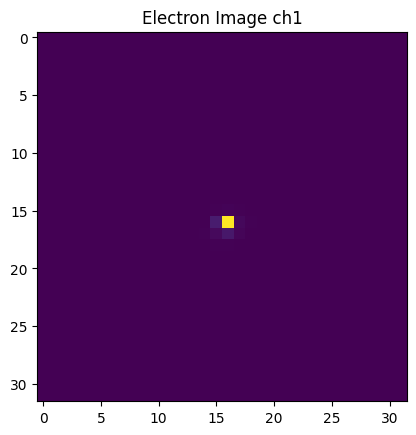

In [14]:
plt.imshow(data_inputs['image'][0,0:1,:,:].permute(1,2,0))  # Assuming it's a 2-channel image; adjust if needed  cmap='gray'
plt.title('Electron Image ch1')
plt.show()

In [ ]:
'''
my_conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
output=my_conv1((data_inputs['image'][:,0:1,:,:]))
print(output.shape)
relu = nn.ReLU()
output=output.view(BATCH_SIZE,-1)
print(output.shape)
fc = nn.Linear(output.shape[1],2)
fc(output)

'''

In [ ]:
'''
class MyModel(nn.Module):

    def __init__(self, num_classes=1,dropout_rate=.2):
        super().__init__()
        self.my_conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.my_conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.my_conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.Linear1=nn.Linear(24*24*8,24*24*1)
        self.Linear2=nn.Linear(24*24*1,24*8)
        self.Linear3=nn.Linear(24*8,4)

        self.Linear=nn.Linear(4,num_classes)

    def forward(self, x):
        x['image'] =self.my_conv1(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        x['image'] =self.my_conv2(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        x['image'] =self.my_conv3(x['image'])
        x['image'] =x['image'].view(BATCH_SIZE,-1)

        x['image'] =self.Linear1(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        x['image'] =self.Linear2(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        x['image'] =self.Linear3(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        x['image'] =self.Linear(x['image'])
        return x['image']

'''

In [45]:
import torch
import torch.nn as nn

class My2Model(nn.Module):

    def __init__(self, num_classes=1, dropout_rate=0.2):
        super().__init__()

        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        #self.conv3=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1)
        #self.conv4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        #self.conv5=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.b1=nn.BatchNorm2d(16)
        self.b2=nn.BatchNorm2d(32)
        #self.b3=nn.BatchNorm2d(16)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(0.1)
        self.fc1=nn.Linear(8*8*32+8*8*32,8*8*32)
        self.fc2=nn.Linear(8*8*32,8*8)
        self.fc3=nn.Linear(8*8,16)
        self.fc4=nn.Linear(16,8)
        self.fc5=nn.Linear(8,2)
        self.out=nn.Linear(32,1)


    def forward(self, x):
        channel1 = x['image'][:, 0:1, :, :]  # Extract first channel
        channel2 = x['image'][:, 1:2, :, :]  # Extract second channel

        convchannel1=self.relu(self.b1(self.conv1(self.pool(self.pool(channel1)))))
        convchannel2=self.relu(self.b1(self.conv1(self.pool(self.pool(channel2)))))

        convchannel1 = convchannel1.view(convchannel1.size(0), -1)
        convchannel2 = convchannel2.view(convchannel2.size(0), -1)
        convchannel = torch.cat([convchannel1, convchannel2], dim=1)

        #convchannel = self.out(convchannel)


        '''
        convchannel = self.fc1(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.fc2(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.fc3(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.fc4(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.fc5(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.dropout(convchannel)
        '''




        '''
        #working code

        convchannel1=self.pool(self.relu(self.b1(self.conv1(channel1))))
        convchannel1=self.pool(self.relu(self.b2(self.conv2(convchannel1))))
        convchannel1 = convchannel1.view(convchannel1.size(0), -1)

        convchannel2=self.pool(self.relu(self.b1(self.conv1(channel2))))
        convchannel2=self.pool(self.relu(self.b2(self.conv2(convchannel2))))
        #convchannel2=self.pool(self.relu(self.b3(self.conv3(convchannel2))))
        convchannel2 = convchannel2.view(convchannel2.size(0), -1)

        convchannel = torch.cat([convchannel1, convchannel2], dim=1)

        convchannel = self.fc1(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.fc2(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.fc3(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.fc4(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.fc5(convchannel)
        convchannel = self.relu(convchannel)

        convchannel = self.dropout(convchannel)

        convchannel = self.out(convchannel)
        '''

        '''
        x=self.pool(F.relu(self.b1(self.conv1(x))))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.b2(self.conv3(x))))
        x=self.pool(F.relu(self.conv4(x)))
        x=self.pool(F.relu(self.b3(self.conv5(x))))
        x=x.view(-1,256)
        x = self.dropout(x)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)
        '''

        return convchannel


In [46]:
model = My2Model(num_classes=1)
model.to(device)
print(model)

My2Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=2, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [39]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs in data_loader:
            is_last_batch = data_inputs['image'].shape[0] < BATCH_SIZE
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_inputs['label']).sum()
            num_preds += BATCH_SIZE

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    return acc

In [40]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_module = nn.BCEWithLogitsLoss()


def train_model(model, optimizer, data_loader, val_loader,loss_module, num_epochs=EPOCHS):
    train_losses = []  # Changed variable name from train_loss to train_losses
    val_losses = []

    # Set model to train mode
    model.train()
    running_loss = 0.0
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs in data_loader:
            # Check if the current batch is the last one
            is_last_batch = data_inputs['image'].shape[0] < BATCH_SIZE
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            # Ensure that the predictions have the same data type as the labels
            preds = preds.squeeze(dim=1).to(data_inputs['label'].float())

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_inputs['label'].float())

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            running_loss += loss.item() * BATCH_SIZE # batch_size

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        #validation plase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
          for data_inputs in val_loader:
            is_last_batch = data_inputs['image'].shape[0] < BATCH_SIZE
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            # Ensure that the predictions have the same data type as the labels
            preds = preds.squeeze(dim=1).to(data_inputs['label'].float())

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_inputs['label'].float())
            running_loss += loss.item() * BATCH_SIZE
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss {train_loss}, Validation Loss {val_loss}")
        eval_model(model, test_loader)

In [47]:
train_model(model, optimizer, train_loader, val_loader, loss_module)

  0%|          | 0/40 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
'''
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs in data_loader:
            is_last_batch = data_inputs['image'].shape[0] < BATCH_SIZE
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_inputs['label']).sum()
            num_preds += BATCH_SIZE

    acc = true_preds / num_preds
    return acc
    '''

In [ ]:
#eval_model(model, test_loader)

tensor(0.7020, device='cuda:0')